<a href="https://colab.research.google.com/github/Dushxn/Deep-Learning-Project/blob/Shaini-Dev/PlantVillageMobileNetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, pathlib, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# **Importing Plantvillage Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your zip file in Drive
zip_path = "/content/drive/MyDrive/DataSet/plantvillage.zip"

# Unzip into /content (fastest for Colab)
!unzip -q "$zip_path" -d /content/

# Check extracted folder name (sometimes it's "PlantVillage" or similar)
!ls /content


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 drive	'plantvillage dataset'	 sample_data


In [ ]:
import os, pathlib

DATA_DIR = "/content/plantvillage dataset/color"   # change if the extracted folder name differs
assert os.path.exists(DATA_DIR), "Check folder name after unzip!"
print("Dataset root:", DATA_DIR)


Dataset root: /content/plantvillage dataset/color


## **Dataset Analysis**

inspect folder structure and counts

In [ ]:
root = pathlib.Path(DATA_DIR)
# If dataset has 'train'/'test' folders or 'plant_village' etc, adapt this snippet.
# We'll assume images are organized in subfolders per class:
classes = [p.name for p in root.iterdir() if p.is_dir()]
classes = sorted(classes)
print(f"Found {len(classes)} classes.")
for c in classes[:30]:
    cnt = len(list(root.joinpath(c).glob('*')))
    print(f"{c}: {cnt} images")


Found 38 classes.
Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mil

visualize class distribution (bar plot)

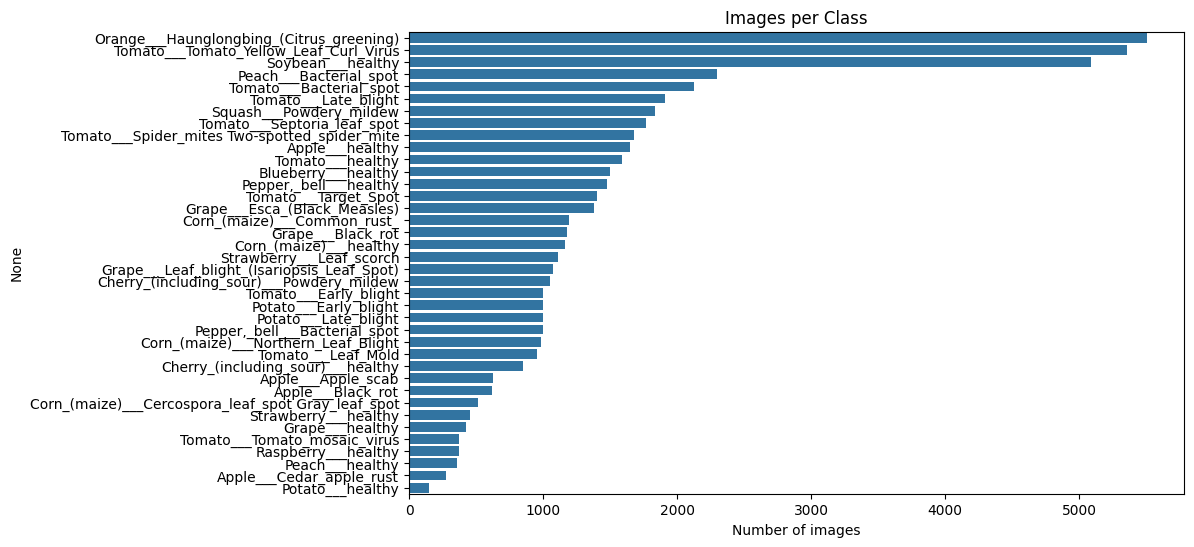

In [ ]:
counts = {}
for c in classes:
    counts[c] = len(list(root.joinpath(c).glob('*')))
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=counts_df['count'].values, y=counts_df.index)
plt.title("Images per Class")
plt.xlabel("Number of images")
plt.show()


show sample images per class

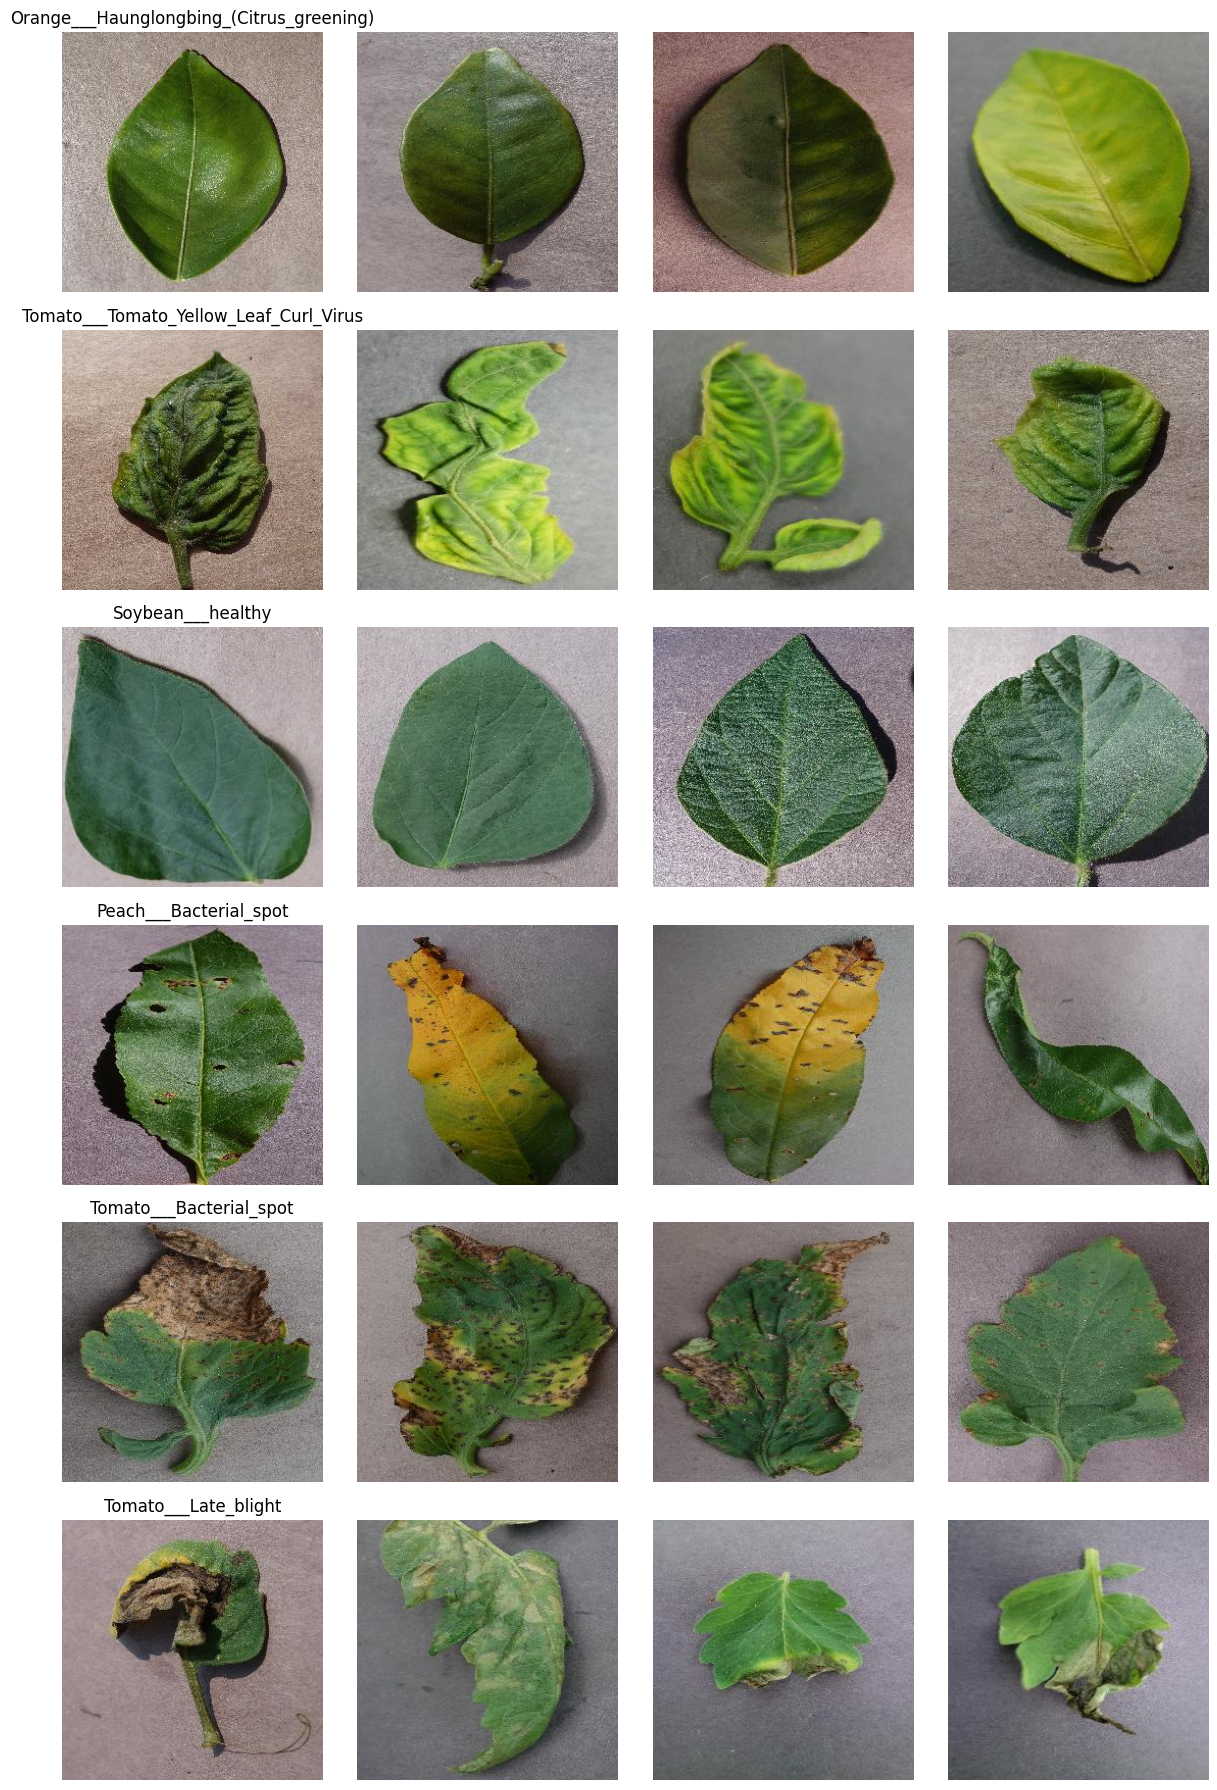

In [ ]:
import matplotlib.image as mpimg
def show_samples(classes, n_per_class=3, img_size=(224,224)):
    plt.figure(figsize=(n_per_class*3, len(classes)*3))
    i = 1
    for row, c in enumerate(classes):
        # Filter out directories and only include files
        imgs = [p for p in root.joinpath(c).glob('*') if p.is_file()][:n_per_class]
        for col, img_path in enumerate(imgs):
            ax = plt.subplot(len(classes), n_per_class, i)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            ax.set_title(c if col==0 else "")
            ax.axis('off')
            i += 1
    plt.tight_layout()
# show top 6 classes to avoid huge plot
show_samples(list(counts_df.index[:6]), n_per_class=4)

## **Data Preprocessing**

In [ ]:
# Define key parameters
IMG_SIZE = (124, 124) # Resized image
BATCH_SIZE = 16

# Create the training dataset (80% of the data)
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123, # Seed for reproducibility
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Create the validation dataset (20% of the data)
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Get the class names (they are inferred in alphabetical order by the function)
class_names = train_ds.class_names
print("Class names:", class_names)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Toma

Configuring for Performance

In [ ]:
# This version streams from disk and uses much less RAM
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
# Create a data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

Train Models Below

In [ ]:
# 🌿 MobileNetV2 (Improved Version) - Final Version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import pathlib

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


(a) Define Base Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

# Load pretrained MobileNetV2 (without top)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers initially
base_model.trainable = False
base_model.summary()


/tmp/ipython-input-2971468195.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 62, 62,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 62, 62,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 62, 62,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 62, 62,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 62, 62,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 62, 62,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 62, 62,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 62, 62,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 62, 62,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 62, 62,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 62, 62,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 63, 63,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 31, 31,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 31, 31,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 31, 31,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 31, 31,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

(b) Data Augmentation & Custom Top Layers

(This part shows your performance improvement — not a “mere function call”)

In [ ]:
# ✅ Explicit data augmentation for better generalization
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# Build full model
inputs = keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)  # Apply augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # Scale to [-1,1]
x = base_model(x, training=False)  # Base model features

# Custom classifier head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs, name="MobileNetV2_Improved")
model.summary()


Model: "MobileNetV2_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596,710 (9.91 MB)

 Trainable params: 338,214 (1.29 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

(c) Compile the Model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


(d) Train the Model (Feature Extraction)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 103s 27ms/step - accuracy: 0.6954 - loss: 1.1007 - val_accuracy: 0.8776 - val_loss: 0.3864
Epoch 2/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - accuracy: 0.8244 - loss: 0.5538 - val_accuracy: 0.9011 - val_loss: 0.3105
Epoch 3/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 69s 23ms/step - accuracy: 0.8330 - loss: 0.5159 - val_accuracy: 0.9045 - val_loss: 0.2984
Epoch 4/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - accuracy: 0.8417 - loss: 0.4921 - val_accuracy: 0.9088 - val_loss: 0.2771
Epoch 5/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - accuracy: 0.8506 - loss: 0.4623 - val_accuracy: 0.9133 - val_loss: 0.2687
Epoch 6/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.8560 - loss: 0.4485 - val_accuracy: 0.9171 - val_loss: 0.2571
Epoch 7/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 92s 27ms/step - accuracy: 0.8581 - loss: 0.4320 - val_accuracy: 0.9170 - val_loss: 0.2583
Epoch 8/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - accuracy: 0.8626 

(e) Fine-Tuning (Unfreeze Last 30 Layers)

In [ ]:
# Unfreeze part of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with smaller learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Added learning rate scheduler (small improvement)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 111s 34ms/step - accuracy: 0.6935 - loss: 1.0679 - val_accuracy: 0.8984 - val_loss: 0.3165 - learning_rate: 1.0000e-05
Epoch 2/15
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 110s 37ms/step - accuracy: 0.8165 - loss: 0.5829 - val_accuracy: 0.9118 - val_loss: 0.2636 - learning_rate: 1.0000e-05
Epoch 3/15
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 101s 34ms/step - accuracy: 0.8515 - loss: 0.4560 - val_accuracy: 0.9259 - val_loss: 0.2209 - learning_rate: 1.0000e-05
Epoch 4/15
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 143s 34ms/step - accuracy: 0.8762 - loss: 0.3855 - val_accuracy: 0.9348 - val_loss: 0.1936 - learning_rate: 1.0000e-05
Epoch 5/15
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 98s 33ms/step - accuracy: 0.8893 - loss: 0.3349 - val_accuracy: 0.9396 - val_loss: 0.1824 - learning_rate: 1.0000e-05
Epoch 6/15
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 101s 34ms/step - accuracy: 0.9028 - loss: 0.3003 - val_accuracy: 0.9454 - val_loss: 0.1673 - learning_rate: 1.0000e-05
Epoch 7/15
2716/2716 ━━━━━━━━━━━━━━

save the model to the drive

In [ ]:
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define folder & model path
folder_path = '/content/drive/MyDrive/plant_model'
save_path = os.path.join(folder_path, 'mobilenetCorrect_model.keras')

# ✅ Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Save model
model.save(save_path)

print(f"✅ Model saved successfully at: {save_path}")


Mounted at /content/drive
✅ Model saved successfully at: /content/drive/MyDrive/plant_model/mobilenetCorrect_model.keras


(f) Evaluate Model

In [ ]:
loss, acc = model.evaluate(val_ds)
acc_percentage = acc * 100
print(f"Validation Accuracy: {acc_percentage:.2f}%")
print(f"Validation Loss: {loss:.4f}")



679/679 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9671 - loss: 0.1041
Validation Accuracy: 96.46%
Validation Loss: 0.1105


save the model

In [ ]:
# Save the trained model
model.save("/content/mobilenetv2_plantvillage.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


(g) Visualize Accuracy and Loss

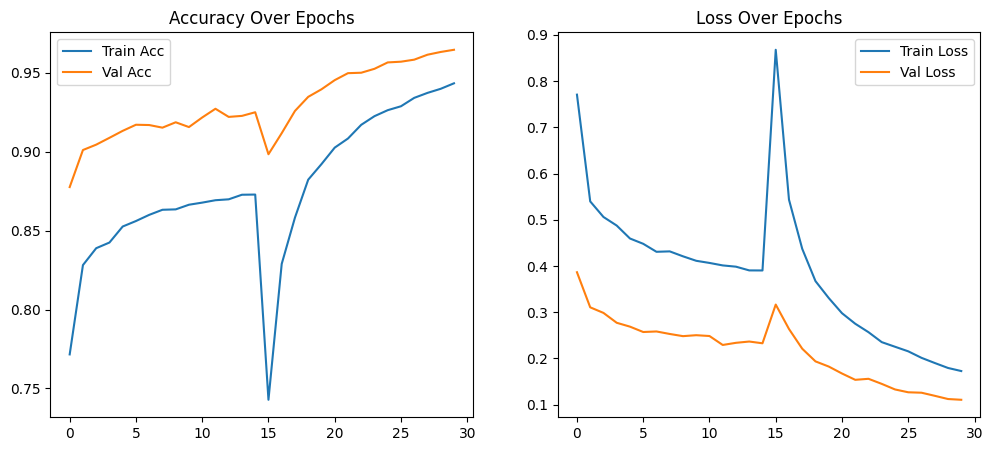

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
losses = history.history['loss'] + history_fine.history['loss']
val_losses = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()
